In [1]:
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
%matplotlib inline

### Cross validation

In [2]:
crossval_chr7 = pd.read_table('../results/admixture/crossvalidation/CV_chr7_logs.txt', delimiter = ' ', header = None)
crossval_chrX = pd.read_table('../results/admixture/crossvalidation/CV_chrX_logs.txt', delimiter = ' ', header = None)

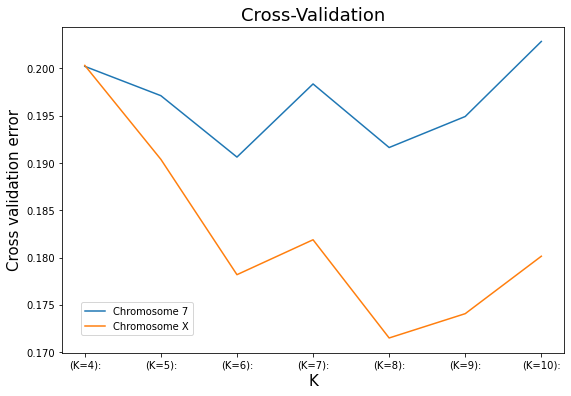

In [3]:
fig, ax = plt.subplots(figsize=(9, 6))
ax.plot(crossval_chr7[2], crossval_chr7[3], label='Chromosome 7')
ax.plot(crossval_chrX[2], crossval_chrX[3], label='Chromosome X')

ax.set_title('Cross-Validation', size = 18)
ax.set_xlabel('K', size = 15)
ax.set_ylabel('Cross validation error', size = 15)
ax.legend(bbox_to_anchor = (0.27, 0.17), fontsize=10)
plt.savefig('../figures/cross_validation.pdf')

### Plotting the ancestral proportions
Reading in metadata as well as all the Q-files from the ADMIXTURE output

In [4]:
pop = pd.read_table("../data/metadata.txt", sep=" ")   # Metadata
pop = pop[pop['Sex'] == 'F']
filenames_chr7 = glob.glob('../results/admixture/chr7_females/chr7_females.pruned.*.Q')        # Q-files from chromosome 7
filenames_chrX = glob.glob('../results/admixture/chrX_females/chrX_females.pruned.*.Q')        # Q-files from chromosome X

Reading in the output from ADMIXTURE by using two functions; one to create the df and one to sort the list of dfs.

In [5]:
def load_Q(file):
    df = pd.read_table(file, delimiter = ' ', header = None).round(decimals=3)
    return df
def sort_Q(lst):
    lst.sort(key=lambda x: len(list(x.columns.values)))
    return lst

In [6]:
chr7 = sort_Q([load_Q(df) for df in filenames_chr7])
chrX = sort_Q([load_Q(df) for df in filenames_chrX])

Now, each df in the two lists can be reordered (Kaspers function).

In [7]:
def reorder_cols_on_pure_indivs(df1, df2):
    
    # get pure ones
    pure2 = df2.index[(df2 == 1).any(axis=1)].tolist()
    
    # indices for K pure individuals
    pure_idx = []
        
    # for each K (color)
    for i in range(len(df1.columns)):
       # find an individual pure for this color in df1 
        pure1 = df1.index[df1.loc[:, i] == 1].tolist()
        
        # only those that are also  pure in df2
        pure1 = [x for x in pure1 if x in pure2]

        # we want each pure idx in df2 to be 1 for a different column
        # so remove all from pure2 that have 1 in col i:
        pure2 = [x for x in pure2 if df2.loc[x, i] != 1]
        
        # we want at most one
        pure1 = pure1[:1]

        # add pure individual to list
        pure_idx.extend(pure1)

    # extract those individuals from both data sets
    # we also transpose because it is easier to work with rows than cols
    m1 = df1.loc[pure_idx, :].T.to_numpy()
    m2 = df2.loc[pure_idx, :].T.to_numpy()
    
    # for each row in m1, find the index of that row in m2
    idx = [np.where(np.all(m1[i]==m2,axis=1))[0][0] for i in range(len(m1))]
    
    # make a copy of the df2 data frame to reorder
    reordered_df = df2.copy()
    
    # swap pairs of columns if they represent identify pure
    for i, (a, b) in enumerate(zip(idx, df1.columns.values)):
        if m1[i].sum() == 1:
            reordered_df.iloc[:, [a, b]] = reordered_df.iloc[:, [b, a]]

    # reset column names to be same as df1
    reordered_df.columns = df1.columns.values

    return reordered_df

In [8]:
def reorder_chr7(df):
    reordered_chr7 = df.sort_values(by = list(df.columns.values))
    return reordered_chr7

def reorder_chrX(df7, dfx):
    reordered_chrX = dfx.reindex(df7.index)
    cols_ordered_chrX = reorder_cols_on_pure_indivs(df7, reordered_chrX)
    return cols_ordered_chrX

In [9]:
def add_pop(df, pop):
    pop = pop.reset_index()
    pop = pop.reindex(df.index, axis=0)
    df = df.set_index(pop['Species'] + '(' + df.index.astype(str) + ')')
    return df

In [10]:
chr7_sorted = [reorder_chr7(df) for df in chr7]
chrX_sorted = [reorder_chrX(x, y) for x, y in zip(chr7_sorted, chrX)]

Adding the population name to each individual

In [11]:
chr7_sorted_names = [add_pop(df, pop) for df in chr7_sorted]
chrX_sorted_names = [add_pop(df, pop) for df in chrX_sorted]

In [12]:
def plot_admixture(chr7, chrX, K):
    fig, axes = plt.subplots(figsize=(5.5, 3), nrows=2, ncols=1, sharex=True)
    
    ax = chr7.plot(ax=axes[0], kind='bar', ylim=(0, 1), stacked=True, width = 0.8, alpha=0.9, rot = 90)
    ax.set_title('K = {}'.format(K), fontsize=10)
    ax = chrX.plot(ax=axes[1], kind='bar', ylim=(0, 1), stacked=True, width = 0.8, alpha=0.9, rot = 90)
    
    for ax in fig.get_axes():
        ax.xaxis.set_tick_params(labelsize=4)
        ax.yaxis.set_tick_params(labelsize=5)
        ax.get_legend().remove()
    
    rows = ['Chromosome {}'.format(col) for col in ['7', 'X']]
    
    for ax, row in zip(axes[:], rows):
        ax.set_ylabel(row, size = 6)
    
    fig.tight_layout()
    plt.show
    plt.savefig('../figures/K_{}.pdf'.format(K), bbox_inches='tight')

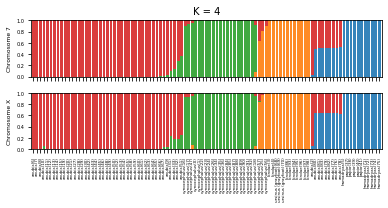

In [13]:
plot_admixture(chr7_sorted_names[0], chrX_sorted_names[0], 4)

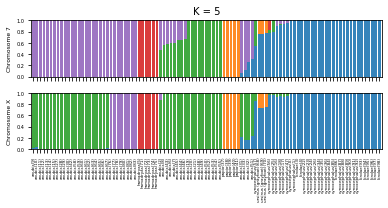

In [14]:
plot_admixture(chr7_sorted_names[1], chrX_sorted_names[1], 5)

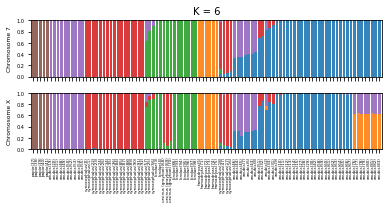

In [15]:
plot_admixture(chr7_sorted_names[2], chrX_sorted_names[2], 6)

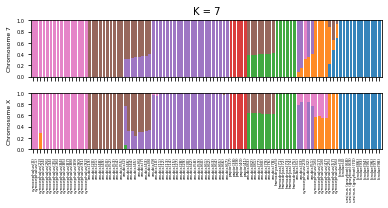

In [16]:
plot_admixture(chr7_sorted_names[3], chrX_sorted_names[3], 7)

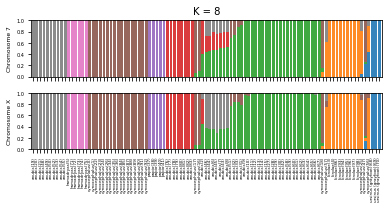

In [17]:
plot_admixture(chr7_sorted_names[4], chrX_sorted_names[4], 8)

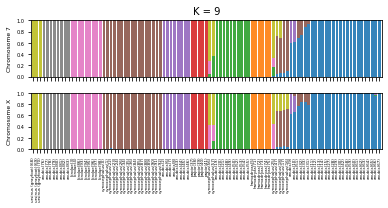

In [18]:
plot_admixture(chr7_sorted_names[5], chrX_sorted_names[5], 9)

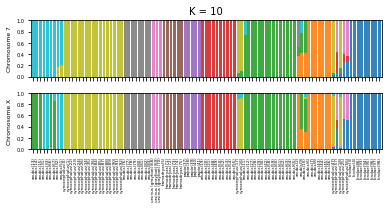

In [19]:
plot_admixture(chr7_sorted_names[6], chrX_sorted_names[6], 10)